In [1]:
import numpy as np

import librosa
from librosa.display import waveshow, specshow

import torchaudio
import torch
from torchaudio import transforms as T 
from torchaudio import functional as F 

from matplotlib import pyplot as plt

In [2]:
def plot_spectrogram_from_feature(S: np.ndarray, sample_rate:int, convert_to_mel:bool=False, n_mels:int=108, **stft_params):
    if len(S.shape) == 2:
        S = np.expand_dims(S, axis=0)
        print(S.shape)
    # Apply FFT & Calculate the Magnitude Spectrum
    if convert_to_mel:
        S_log = librosa.power_to_db(S, ref=np.max)
        y_axis = 'mel'
    else:
        S_log = librosa.amplitude_to_db(np.abs(S), ref=np.max)
        y_axis = 'linear'

    num_channels, num_mels, num_frames = S.shape
    figure, axes = plt.subplots(nrows=num_channels, ncols=1)

    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        # axes[c].plot(frequency[:num_frequency_bins], magnitude_spectrum[c,:num_frequency_bins])
        im = specshow(S_log[c], sr=sample_rate, x_axis='time', y_axis=y_axis, ax=axes[c])
        # axes[c].grid(True)
        axes[c].label_outer()
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        else:
            axes[c].set_ylabel(f"Mel")
    figure.suptitle("Spectrogram")
    figure.colorbar(im, ax=axes, format="%+2.0f dB")

    plt.show(block=False)



In [3]:
audio_path = '../medleydb/medleydb/data/Audio/Phoenix_ScotchMorris/Phoenix_ScotchMorris_MIX.wav'
metadata = torchaudio.info(audio_path)
song_duration = metadata.num_frames/metadata.sample_rate # in seconds
m,s = divmod(song_duration, 60)
print(metadata)
print(f'Song duration: {song_duration:.2f}s ({m:.0f}m{s:.0f}s)')

AudioMetaData(sample_rate=44100, num_frames=7811926, num_channels=2, bits_per_sample=16, encoding=PCM_S)
Song duration: 177.14s (2m57s)


In [4]:
#load audio
signal, sample_rate = torchaudio.load(audio_path)

# cut audio if any
offset = 0
dur = None

if dur:
    signal = signal[:,offset:offset+(dur*sample_rate)]

# convert to mono
signal_mono = torch.mean(signal, dim=0)


In [17]:
HOP = 512
n_fft = 1024
win_length = None
n_mels = 128#108-21+1

melspectrogram_extractor = T.MelSpectrogram(
    sample_rate=44100,
    hop_length=HOP,
    n_fft=n_fft,
    win_length=win_length,
    pad_mode='constant',
    center=True,
    f_min=librosa.midi_to_hz(21),
    f_max=None,
    n_mels=n_mels,
    power=2.0,
    norm="slaney",
)

S = melspectrogram_extractor(signal)

S_librosa = librosa.feature.melspectrogram(
    y=signal_mono.numpy(),
    sr=44100,
    hop_length=HOP,
    n_fft=n_fft,
    win_length=win_length,
    pad_mode='constant',
    center=True,
    fmin=librosa.midi_to_hz(21),
    fmax=None,
    n_mels=n_mels,
    power=2.0,
    htk=True)

(1, 128, 15258)


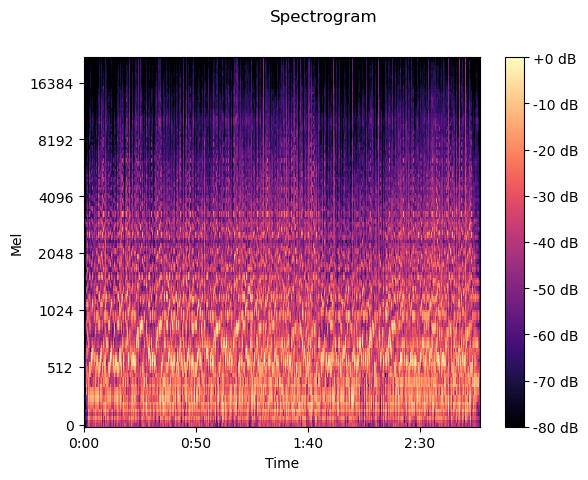

In [18]:
plot_spectrogram_from_feature(S_librosa, sample_rate, convert_to_mel=True)

In [19]:
import os
import pandas as pd
import torch
from pitch_tracker.utils.files import save_pickle, load_pickle

In [32]:
out_obj_path = '../content/test/test_mel_feature.pkl'
out_npy_path = '../content/test/test_mel_feature.npy'
out_torch_path = '../content/test/test_mel_feature.torch'
save_pickle(S, out_obj_path)
np.save(out_npy_path, S.numpy())
torch.save(S, out_torch_path)

In [1]:
S_pickle = load_pickle(out_obj_path)
S_np = np.load(out_npy_path)
S_torch = torch.load(out_torch_path)
print(S_pickle.shape)
print(S_np.shape)

NameError: name 'load_pickle' is not defined